## 1. 任务介绍
> 介绍任务的基本内容，以及问题的公式化
---
文本分类是自然语言处理中最基础的任务之一，主要是通过分类器将给定的文本划分到特定的类，比如情绪分类、垃圾邮件分类、电影评论分类等。具体任务公式化如下：
$$
\begin{aligned}
文本 ： &X = (x_1,x_2,\dots,x_n) \\
类标签 ：& Y = (y_1,y_2,\dots,y_n)\\
模型 ：& f: x_i  \xrightarrow{f} y_i, \hspace{1em} i = 1,2, \dots,n
\end{aligned}
$$
本文选用Kaggle的电影评论情感分析来作为任务。

## 2.环境准备

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics 

import nltk
from nltk.corpus import stopwords

N_CLASSES = 2 # 类别数

## 3. 数据预处理
> 需要对数据进行清洗
---

处理步骤大致如下：
    1. 去除html标签
    2. 去除标点
    3. 切分成词
    4. 去除停用词
    5. 重组为新的句子

In [2]:
# 0. 先准备数据
file_path = '../data/IMDB/labeledTrainData.tsv'
df = pd.read_csv(file_path,sep='\t',escapechar='\\')
print('Number of samples:{}'.format(len(df)))
df.head()

Number of samples:25000


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
eng_stopwords = stopwords.words('english') #定义停用词

def text_clean(text):
    text = BeautifulSoup(text,'html.parser').get_text() #去除html标签
    text = re.sub(r'[^a-zA-Z]',' ',text) #去除标点
    words = text.lower().split()  #全部转成小写，然后按空格分词
    words = [w for w in words if w not in eng_stopwords] #去除停用词
    return ' '.join(words)  #重组成新的句子

df['clean_review'] = df.review.apply(text_clean)
df.head()

,id,sentiment,review,clean_review
0,5814_8,1,With all this stuff going down at the moment w...,stuff going moment mj started listening music ...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin...",classic war worlds timothy hines entertaining ...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film starts manager nicholas bell giving welco...
3,3630_4,0,It must be assumed that those who praised this...,must assumed praised film greatest filmed oper...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious explo...


## 4. 文本特征表示 
> 文本向量化，并提取特征，分为离散法和分布式法(此处主要讲离散法)
---
离散法主要有以下几种方法：
 1. 词袋模型(Bag of word): 用单词频数来表示文本，不考虑文本的语法结构和单词顺序
 2. 独热编码(One-hot): 将文本表示成整个词标长度的向量，出现过的词为1，否则为0
 3. n元语法(n-gram): 对词袋模型的一种改进，即用n个词或词组组成的字符串作为特征，然后再用词袋模型的方法将文本表示为向量形式
 4. TF-IDF： 用词的TF-IDF来表示文本
 
<span style="color:red">注：其实上述方法都可以看作是词袋模型</span>

In [4]:
# 1. 使用统计词频，作为文本特征
vectorizer_feq = CountVectorizer(max_features=5000) #取词频为前5000的词
data_freq = vectorizer_feq.fit_transform(df.clean_review).toarray()
print("词频为特征的文本-单词矩阵维度:",data_freq.shape)

# 2. 使用bigram，作为文本特征
vectorizer_bigram = CountVectorizer(ngram_range=(2,2),max_features=1000,token_pattern=r'\b\w+\b', min_df=1)
# analyze = vectorizer_bigram.build_analyzer()
# print("bi-gram示例：",analyze(df.clean_review[0]))#bi-gram举例
data_bigram = vectorizer_bigram.fit_transform(df.clean_review).toarray()
print("bi-gram为特征的文本-单词矩阵维度：",data_bigram.shape)

# 2. 使用tfidf, 作为文本特征
vectorizer_tfidf = TfidfVectorizer(max_features=5000)
data_tfidf = vectorizer_tfidf.fit_transform(df.clean_review).toarray()

print("TF-IDF为特征的文本-单词矩阵维度：",data_tfidf.shape)

词频为特征的文本-单词矩阵维度: (25000, 5000)
bi-gram为特征的文本-单词矩阵维度： (25000, 1000)
TF-IDF为特征的文本-单词矩阵维度： (25000, 5000)


## 5. 辅助函数
> 包括数据批量生成器，softmax函数，预测函数，评估函数

In [5]:
# 定义数据批量生成器
def batch_generator(data, batch_size, shuffle=True):
    X, Y = data
    n_samples = X.shape[0]
    indices = np.arange(n_samples)
    if shuffle:
        np.random.shuffle(indices)  # 打乱顺序

    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]


# softmax函数
def softmax(scores):
    sum_exp = np.sum(np.exp(scores), axis=1, keepdims=True)
    softmax = np.exp(scores) / sum_exp
    return softmax

# 预测函数
def predict(w,x):
    scores = np.dot(x, w.T)
    probs = softmax(scores)

    return np.argmax(probs, axis=1).reshape(-1, 1)

# 评估函数
def evaluate(y_true,y_pred):
    precision = metrics.precision_score(y_true,y_pred)
    recall = metrics.recall_score(y_true,y_pred)
    f1_score = metrics.f1_score(y_true,y_pred)

    return precision,recall,f1_score


# 将数据集分割
def split_data(x, y, val_split=0.2):
    n_samples = x.shape[0]

    indices = np.random.permutation(n_samples)
    split = int(n_samples * (1 - val_split))
    training_idx = indices[:split]
    valid_idx = indices[split:]

    train_x = x[training_idx]
    train_y = y[training_idx]

    valid_x = x[valid_idx]
    valid_y = y[valid_idx]

    return train_x, train_y, valid_x, valid_y

## 6. 构建分类器
> 此处以softmax regression作为分类器

In [6]:
def valid(w, val_x, val_y, batch_size):
    val_loss = []
    val_gen = batch_generator((val_x, val_y), batch_size, shuffle=False)

    for batch_x, batch_y in val_gen:
        scores = np.dot(batch_x, w.T)
        prob = softmax(scores)

        y_one_hot = np.eye(N_CLASSES)[batch_y]
        # 损失函数
        loss = -(1.0 / len(batch_x)) * np.sum(y_one_hot * np.log(prob))
        val_loss.append(loss)

    return np.mean(val_loss)


def train(train_x,
          train_y,
          valid_x,
          valid_y,
          lr=0.1,
          batch_size=128,
          epochs=5000,
          early_stop=None):

    n_features = train_x.shape[1]
    w = np.random.rand(N_CLASSES, n_features)

    train_all_loss = []
    val_all_loss = []
    precision_list = []
    recall_list = []
    f1_score_list = []

    not_improved = 0
    best_val_loss = np.inf
    best_w = None

    for epoch in range(epochs):
        training_gen = batch_generator((train_x, train_y), batch_size)
        train_loss = []
        for batch_x, batch_y in training_gen:
            scores = np.dot(batch_x, w.T)
            prob = softmax(scores)

            y_one_hot = np.eye(N_CLASSES)[batch_y]
            # 损失函数
            loss = -(1.0 / len(batch_x)) * np.sum(y_one_hot * np.log(prob))
            train_loss.append(loss)

            # 梯度下降
            dw = -(1.0 / len(batch_x)) * np.dot((y_one_hot - prob).T, batch_x)
            w = w - lr * dw
            
        val_loss = valid(w, valid_x, valid_y, batch_size)


        val_precision, val_recall, val_f1_score = evaluate(
            valid_y, predict(w, valid_x))

        print(
            "Epoch = {0},the train loss = {1:.4f}, the val loss = {2:.4f}, precision={3:.4f}%, recall={4:.4f}%, f1_score={4:.4f}%"
            .format(epoch, np.mean(train_loss), val_loss, val_precision * 100,
                    val_recall * 100, val_f1_score * 100))

        train_all_loss.append(np.mean(train_loss))
        val_all_loss.append(val_loss)
        precision_list.append(val_precision)
        recall_list.append(val_recall)
        f1_score_list.append(val_f1_score)

        if early_stop is not None:
            if val_loss <= best_val_loss:
                best_val_loss = val_loss
                best_w = w
                not_improved = 0
            else:
                not_improved += 1

            if not_improved > early_stop:
                print("Validation performance didn\'t improve for {} epochs. "
                      "Training stops.".format(early_stop))
                break

    return best_w, train_all_loss, val_all_loss,precision_list,recall_list,f1_score_list

## 7.训练 

### 7.1 以BOW为特征进行训练 

In [7]:
label = df['sentiment'].values

train_x, trian_y, val_x, val_y = split_data(data_tfidf, label)

w, train_all_loss, val_all_loss, precision_list, recall_list, f1_score_list = train(train_x,
                                                 trian_y,
                                                 val_x,
                                                 val_y,
                                                 early_stop=10)

Epoch = 0,the train loss = 0.7187, the val loss = 0.7081, precision=50.2999%, recall=54.1129%, f1_score=54.1129%
Epoch = 1,the train loss = 0.7052, the val loss = 0.6959, precision=52.9435%, recall=54.0323%, f1_score=54.0323%
Epoch = 2,the train loss = 0.6927, the val loss = 0.6845, precision=55.4871%, recall=54.4355%, f1_score=54.4355%
Epoch = 3,the train loss = 0.6809, the val loss = 0.6739, precision=57.7277%, recall=55.7258%, f1_score=55.7258%
Epoch = 4,the train loss = 0.6701, the val loss = 0.6638, precision=59.8488%, recall=57.4597%, f1_score=57.4597%
Epoch = 5,the train loss = 0.6597, the val loss = 0.6542, precision=61.9514%, recall=58.6290%, f1_score=58.6290%
Epoch = 6,the train loss = 0.6498, the val loss = 0.6451, precision=63.3035%, recall=59.9597%, f1_score=59.9597%
Epoch = 7,the train loss = 0.6405, the val loss = 0.6364, precision=64.9235%, recall=61.5726%, f1_score=61.5726%
Epoch = 8,the train loss = 0.6313, the val loss = 0.6281, precision=66.6947%, recall=63.9516%, f

Epoch = 72,the train loss = 0.4064, the val loss = 0.4192, precision=83.0371%, recall=86.6532%, f1_score=86.6532%
Epoch = 73,the train loss = 0.4049, the val loss = 0.4179, precision=83.1913%, recall=86.6129%, f1_score=86.6129%
Epoch = 74,the train loss = 0.4034, the val loss = 0.4166, precision=83.3010%, recall=86.6935%, f1_score=86.6935%
Epoch = 75,the train loss = 0.4017, the val loss = 0.4153, precision=83.3527%, recall=86.8145%, f1_score=86.8145%
Epoch = 76,the train loss = 0.4007, the val loss = 0.4141, precision=83.3204%, recall=86.8145%, f1_score=86.8145%
Epoch = 77,the train loss = 0.3992, the val loss = 0.4128, precision=83.3850%, recall=86.8145%, f1_score=86.8145%
Epoch = 78,the train loss = 0.3977, the val loss = 0.4116, precision=83.3914%, recall=86.8548%, f1_score=86.8548%
Epoch = 79,the train loss = 0.3963, the val loss = 0.4104, precision=83.3978%, recall=86.8952%, f1_score=86.8952%
Epoch = 80,the train loss = 0.3952, the val loss = 0.4092, precision=83.4429%, recall=86

Epoch = 144,the train loss = 0.3392, the val loss = 0.3597, precision=84.7346%, recall=88.1855%, f1_score=88.1855%
Epoch = 145,the train loss = 0.3388, the val loss = 0.3592, precision=84.7018%, recall=88.1855%, f1_score=88.1855%
Epoch = 146,the train loss = 0.3381, the val loss = 0.3586, precision=84.7674%, recall=88.1855%, f1_score=88.1855%
Epoch = 147,the train loss = 0.3377, the val loss = 0.3581, precision=84.8121%, recall=88.2661%, f1_score=88.2661%
Epoch = 148,the train loss = 0.3366, the val loss = 0.3576, precision=84.8450%, recall=88.2661%, f1_score=88.2661%
Epoch = 149,the train loss = 0.3368, the val loss = 0.3571, precision=84.8508%, recall=88.3065%, f1_score=88.3065%
Epoch = 150,the train loss = 0.3355, the val loss = 0.3567, precision=84.8508%, recall=88.3065%, f1_score=88.3065%
Epoch = 151,the train loss = 0.3352, the val loss = 0.3562, precision=84.8508%, recall=88.3065%, f1_score=88.3065%
Epoch = 152,the train loss = 0.3349, the val loss = 0.3557, precision=84.8450%, 

Epoch = 216,the train loss = 0.3064, the val loss = 0.3322, precision=85.7254%, recall=88.6290%, f1_score=88.6290%
Epoch = 217,the train loss = 0.3059, the val loss = 0.3319, precision=85.7478%, recall=88.5484%, f1_score=88.5484%
Epoch = 218,the train loss = 0.3055, the val loss = 0.3316, precision=85.7533%, recall=88.5887%, f1_score=88.5887%
Epoch = 219,the train loss = 0.3058, the val loss = 0.3314, precision=85.7422%, recall=88.5081%, f1_score=88.5081%
Epoch = 220,the train loss = 0.3050, the val loss = 0.3311, precision=85.7757%, recall=88.5081%, f1_score=88.5081%
Epoch = 221,the train loss = 0.3043, the val loss = 0.3308, precision=85.7478%, recall=88.5484%, f1_score=88.5484%
Epoch = 222,the train loss = 0.3040, the val loss = 0.3305, precision=85.7812%, recall=88.5484%, f1_score=88.5484%
Epoch = 223,the train loss = 0.3042, the val loss = 0.3303, precision=85.8203%, recall=88.5887%, f1_score=88.5887%
Epoch = 224,the train loss = 0.3034, the val loss = 0.3300, precision=85.8203%, 

Epoch = 288,the train loss = 0.2852, the val loss = 0.3161, precision=86.2367%, recall=88.4274%, f1_score=88.4274%
Epoch = 289,the train loss = 0.2850, the val loss = 0.3159, precision=86.2367%, recall=88.4274%, f1_score=88.4274%
Epoch = 290,the train loss = 0.2852, the val loss = 0.3157, precision=86.2367%, recall=88.4274%, f1_score=88.4274%
Epoch = 291,the train loss = 0.2849, the val loss = 0.3155, precision=86.2367%, recall=88.4274%, f1_score=88.4274%
Epoch = 292,the train loss = 0.2845, the val loss = 0.3154, precision=86.2421%, recall=88.4677%, f1_score=88.4677%
Epoch = 293,the train loss = 0.2842, the val loss = 0.3152, precision=86.2761%, recall=88.4677%, f1_score=88.4677%
Epoch = 294,the train loss = 0.2842, the val loss = 0.3150, precision=86.2761%, recall=88.4677%, f1_score=88.4677%
Epoch = 295,the train loss = 0.2836, the val loss = 0.3148, precision=86.2761%, recall=88.4677%, f1_score=88.4677%
Epoch = 296,the train loss = 0.2835, the val loss = 0.3147, precision=86.2761%, 

Epoch = 360,the train loss = 0.2702, the val loss = 0.3054, precision=86.7932%, recall=88.5081%, f1_score=88.5081%
Epoch = 361,the train loss = 0.2706, the val loss = 0.3053, precision=86.7932%, recall=88.5081%, f1_score=88.5081%
Epoch = 362,the train loss = 0.2702, the val loss = 0.3052, precision=86.7932%, recall=88.5081%, f1_score=88.5081%
Epoch = 363,the train loss = 0.2703, the val loss = 0.3050, precision=86.7932%, recall=88.5081%, f1_score=88.5081%
Epoch = 364,the train loss = 0.2697, the val loss = 0.3049, precision=86.8275%, recall=88.5081%, f1_score=88.5081%
Epoch = 365,the train loss = 0.2691, the val loss = 0.3048, precision=86.8275%, recall=88.5081%, f1_score=88.5081%
Epoch = 366,the train loss = 0.2699, the val loss = 0.3047, precision=86.8275%, recall=88.5081%, f1_score=88.5081%
Epoch = 367,the train loss = 0.2694, the val loss = 0.3046, precision=86.8275%, recall=88.5081%, f1_score=88.5081%
Epoch = 368,the train loss = 0.2691, the val loss = 0.3045, precision=86.8275%, 

Epoch = 432,the train loss = 0.2596, the val loss = 0.2979, precision=86.9514%, recall=88.6694%, f1_score=88.6694%
Epoch = 433,the train loss = 0.2586, the val loss = 0.2978, precision=86.9170%, recall=88.6694%, f1_score=88.6694%
Epoch = 434,the train loss = 0.2590, the val loss = 0.2977, precision=86.9170%, recall=88.6694%, f1_score=88.6694%
Epoch = 435,the train loss = 0.2585, the val loss = 0.2976, precision=86.9170%, recall=88.6694%, f1_score=88.6694%
Epoch = 436,the train loss = 0.2583, the val loss = 0.2976, precision=86.9222%, recall=88.7097%, f1_score=88.7097%
Epoch = 437,the train loss = 0.2581, the val loss = 0.2975, precision=86.9222%, recall=88.7097%, f1_score=88.7097%
Epoch = 438,the train loss = 0.2583, the val loss = 0.2974, precision=86.9514%, recall=88.6694%, f1_score=88.6694%
Epoch = 439,the train loss = 0.2579, the val loss = 0.2973, precision=86.9514%, recall=88.6694%, f1_score=88.6694%
Epoch = 440,the train loss = 0.2573, the val loss = 0.2972, precision=86.9514%, 

Epoch = 504,the train loss = 0.2498, the val loss = 0.2924, precision=87.1197%, recall=88.9113%, f1_score=88.9113%
Epoch = 505,the train loss = 0.2495, the val loss = 0.2923, precision=87.1197%, recall=88.9113%, f1_score=88.9113%
Epoch = 506,the train loss = 0.2499, the val loss = 0.2923, precision=87.1197%, recall=88.9113%, f1_score=88.9113%
Epoch = 507,the train loss = 0.2494, the val loss = 0.2922, precision=87.1197%, recall=88.9113%, f1_score=88.9113%
Epoch = 508,the train loss = 0.2488, the val loss = 0.2921, precision=87.1197%, recall=88.9113%, f1_score=88.9113%
Epoch = 509,the train loss = 0.2492, the val loss = 0.2921, precision=87.1542%, recall=88.9113%, f1_score=88.9113%
Epoch = 510,the train loss = 0.2487, the val loss = 0.2920, precision=87.1542%, recall=88.9113%, f1_score=88.9113%
Epoch = 511,the train loss = 0.2492, the val loss = 0.2919, precision=87.1542%, recall=88.9113%, f1_score=88.9113%
Epoch = 512,the train loss = 0.2486, the val loss = 0.2919, precision=87.1542%, 

Epoch = 576,the train loss = 0.2422, the val loss = 0.2882, precision=87.3072%, recall=89.0323%, f1_score=89.0323%
Epoch = 577,the train loss = 0.2423, the val loss = 0.2882, precision=87.3072%, recall=89.0323%, f1_score=89.0323%
Epoch = 578,the train loss = 0.2423, the val loss = 0.2881, precision=87.3072%, recall=89.0323%, f1_score=89.0323%
Epoch = 579,the train loss = 0.2419, the val loss = 0.2880, precision=87.3072%, recall=89.0323%, f1_score=89.0323%
Epoch = 580,the train loss = 0.2415, the val loss = 0.2880, precision=87.3072%, recall=89.0323%, f1_score=89.0323%
Epoch = 581,the train loss = 0.2413, the val loss = 0.2879, precision=87.3123%, recall=89.0726%, f1_score=89.0726%
Epoch = 582,the train loss = 0.2418, the val loss = 0.2879, precision=87.3123%, recall=89.0726%, f1_score=89.0726%
Epoch = 583,the train loss = 0.2413, the val loss = 0.2878, precision=87.3123%, recall=89.0726%, f1_score=89.0726%
Epoch = 584,the train loss = 0.2410, the val loss = 0.2878, precision=87.3123%, 

Epoch = 648,the train loss = 0.2354, the val loss = 0.2850, precision=87.4455%, recall=89.0323%, f1_score=89.0323%
Epoch = 649,the train loss = 0.2351, the val loss = 0.2849, precision=87.4455%, recall=89.0323%, f1_score=89.0323%
Epoch = 650,the train loss = 0.2347, the val loss = 0.2849, precision=87.4455%, recall=89.0323%, f1_score=89.0323%
Epoch = 651,the train loss = 0.2351, the val loss = 0.2849, precision=87.4455%, recall=89.0323%, f1_score=89.0323%
Epoch = 652,the train loss = 0.2348, the val loss = 0.2848, precision=87.4455%, recall=89.0323%, f1_score=89.0323%
Epoch = 653,the train loss = 0.2360, the val loss = 0.2848, precision=87.4455%, recall=89.0323%, f1_score=89.0323%
Epoch = 654,the train loss = 0.2350, the val loss = 0.2847, precision=87.4455%, recall=89.0323%, f1_score=89.0323%
Epoch = 655,the train loss = 0.2344, the val loss = 0.2847, precision=87.4455%, recall=89.0323%, f1_score=89.0323%
Epoch = 656,the train loss = 0.2345, the val loss = 0.2847, precision=87.4455%, 

Epoch = 720,the train loss = 0.2294, the val loss = 0.2824, precision=87.5843%, recall=89.0323%, f1_score=89.0323%
Epoch = 721,the train loss = 0.2293, the val loss = 0.2824, precision=87.5843%, recall=89.0323%, f1_score=89.0323%
Epoch = 722,the train loss = 0.2296, the val loss = 0.2824, precision=87.5843%, recall=89.0323%, f1_score=89.0323%
Epoch = 723,the train loss = 0.2294, the val loss = 0.2824, precision=87.5843%, recall=89.0323%, f1_score=89.0323%
Epoch = 724,the train loss = 0.2301, the val loss = 0.2823, precision=87.5843%, recall=89.0323%, f1_score=89.0323%
Epoch = 725,the train loss = 0.2299, the val loss = 0.2823, precision=87.5843%, recall=89.0323%, f1_score=89.0323%
Epoch = 726,the train loss = 0.2290, the val loss = 0.2823, precision=87.5892%, recall=89.0726%, f1_score=89.0726%
Epoch = 727,the train loss = 0.2293, the val loss = 0.2822, precision=87.5892%, recall=89.0726%, f1_score=89.0726%
Epoch = 728,the train loss = 0.2288, the val loss = 0.2822, precision=87.5892%, 

Epoch = 792,the train loss = 0.2242, the val loss = 0.2805, precision=87.6289%, recall=89.1129%, f1_score=89.1129%
Epoch = 793,the train loss = 0.2244, the val loss = 0.2804, precision=87.6289%, recall=89.1129%, f1_score=89.1129%
Epoch = 794,the train loss = 0.2240, the val loss = 0.2804, precision=87.6636%, recall=89.1129%, f1_score=89.1129%
Epoch = 795,the train loss = 0.2242, the val loss = 0.2804, precision=87.6636%, recall=89.1129%, f1_score=89.1129%
Epoch = 796,the train loss = 0.2249, the val loss = 0.2804, precision=87.6636%, recall=89.1129%, f1_score=89.1129%
Epoch = 797,the train loss = 0.2257, the val loss = 0.2803, precision=87.6636%, recall=89.1129%, f1_score=89.1129%
Epoch = 798,the train loss = 0.2241, the val loss = 0.2803, precision=87.6636%, recall=89.1129%, f1_score=89.1129%
Epoch = 799,the train loss = 0.2238, the val loss = 0.2803, precision=87.6636%, recall=89.1129%, f1_score=89.1129%
Epoch = 800,the train loss = 0.2238, the val loss = 0.2803, precision=87.6685%, 

Epoch = 864,the train loss = 0.2200, the val loss = 0.2789, precision=87.6089%, recall=89.2339%, f1_score=89.2339%
Epoch = 865,the train loss = 0.2203, the val loss = 0.2789, precision=87.6089%, recall=89.2339%, f1_score=89.2339%
Epoch = 866,the train loss = 0.2198, the val loss = 0.2788, precision=87.6089%, recall=89.2339%, f1_score=89.2339%
Epoch = 867,the train loss = 0.2196, the val loss = 0.2788, precision=87.6089%, recall=89.2339%, f1_score=89.2339%
Epoch = 868,the train loss = 0.2197, the val loss = 0.2788, precision=87.6138%, recall=89.2742%, f1_score=89.2742%
Epoch = 869,the train loss = 0.2196, the val loss = 0.2788, precision=87.6138%, recall=89.2742%, f1_score=89.2742%
Epoch = 870,the train loss = 0.2196, the val loss = 0.2788, precision=87.6236%, recall=89.3548%, f1_score=89.3548%
Epoch = 871,the train loss = 0.2200, the val loss = 0.2787, precision=87.6236%, recall=89.3548%, f1_score=89.3548%
Epoch = 872,the train loss = 0.2192, the val loss = 0.2787, precision=87.6236%, 

Epoch = 936,the train loss = 0.2159, the val loss = 0.2777, precision=87.6582%, recall=89.3548%, f1_score=89.3548%
Epoch = 937,the train loss = 0.2157, the val loss = 0.2776, precision=87.6533%, recall=89.3145%, f1_score=89.3145%
Epoch = 938,the train loss = 0.2157, the val loss = 0.2776, precision=87.6533%, recall=89.3145%, f1_score=89.3145%
Epoch = 939,the train loss = 0.2159, the val loss = 0.2776, precision=87.6533%, recall=89.3145%, f1_score=89.3145%
Epoch = 940,the train loss = 0.2162, the val loss = 0.2776, precision=87.6832%, recall=89.2742%, f1_score=89.2742%
Epoch = 941,the train loss = 0.2162, the val loss = 0.2776, precision=87.6187%, recall=89.3145%, f1_score=89.3145%
Epoch = 942,the train loss = 0.2160, the val loss = 0.2776, precision=87.6187%, recall=89.3145%, f1_score=89.3145%
Epoch = 943,the train loss = 0.2150, the val loss = 0.2775, precision=87.5791%, recall=89.2742%, f1_score=89.2742%
Epoch = 944,the train loss = 0.2160, the val loss = 0.2775, precision=87.6485%, 

Epoch = 1008,the train loss = 0.2122, the val loss = 0.2767, precision=87.7826%, recall=89.2339%, f1_score=89.2339%
Epoch = 1009,the train loss = 0.2122, the val loss = 0.2767, precision=87.7826%, recall=89.2339%, f1_score=89.2339%
Epoch = 1010,the train loss = 0.2121, the val loss = 0.2766, precision=87.7826%, recall=89.2339%, f1_score=89.2339%
Epoch = 1011,the train loss = 0.2126, the val loss = 0.2766, precision=87.8175%, recall=89.2339%, f1_score=89.2339%
Epoch = 1012,the train loss = 0.2119, the val loss = 0.2766, precision=87.8175%, recall=89.2339%, f1_score=89.2339%
Epoch = 1013,the train loss = 0.2118, the val loss = 0.2766, precision=87.8175%, recall=89.2339%, f1_score=89.2339%
Epoch = 1014,the train loss = 0.2118, the val loss = 0.2766, precision=87.8175%, recall=89.2339%, f1_score=89.2339%
Epoch = 1015,the train loss = 0.2118, the val loss = 0.2766, precision=87.7826%, recall=89.2339%, f1_score=89.2339%
Epoch = 1016,the train loss = 0.2115, the val loss = 0.2766, precision=8

Epoch = 1079,the train loss = 0.2088, the val loss = 0.2759, precision=87.7478%, recall=89.2339%, f1_score=89.2339%
Epoch = 1080,the train loss = 0.2084, the val loss = 0.2759, precision=87.7478%, recall=89.2339%, f1_score=89.2339%
Epoch = 1081,the train loss = 0.2084, the val loss = 0.2759, precision=87.7478%, recall=89.2339%, f1_score=89.2339%
Epoch = 1082,the train loss = 0.2083, the val loss = 0.2759, precision=87.7478%, recall=89.2339%, f1_score=89.2339%
Epoch = 1083,the train loss = 0.2087, the val loss = 0.2759, precision=87.7478%, recall=89.2339%, f1_score=89.2339%
Epoch = 1084,the train loss = 0.2091, the val loss = 0.2759, precision=87.7478%, recall=89.2339%, f1_score=89.2339%
Epoch = 1085,the train loss = 0.2089, the val loss = 0.2759, precision=87.7478%, recall=89.2339%, f1_score=89.2339%
Epoch = 1086,the train loss = 0.2089, the val loss = 0.2759, precision=87.7478%, recall=89.2339%, f1_score=89.2339%
Epoch = 1087,the train loss = 0.2091, the val loss = 0.2759, precision=8

Epoch = 1150,the train loss = 0.2063, the val loss = 0.2754, precision=87.9571%, recall=89.2339%, f1_score=89.2339%
Epoch = 1151,the train loss = 0.2054, the val loss = 0.2754, precision=87.9571%, recall=89.2339%, f1_score=89.2339%
Epoch = 1152,the train loss = 0.2052, the val loss = 0.2753, precision=87.9571%, recall=89.2339%, f1_score=89.2339%
Epoch = 1153,the train loss = 0.2056, the val loss = 0.2753, precision=87.9571%, recall=89.2339%, f1_score=89.2339%
Epoch = 1154,the train loss = 0.2053, the val loss = 0.2753, precision=87.9571%, recall=89.2339%, f1_score=89.2339%
Epoch = 1155,the train loss = 0.2057, the val loss = 0.2753, precision=87.9571%, recall=89.2339%, f1_score=89.2339%
Epoch = 1156,the train loss = 0.2063, the val loss = 0.2753, precision=87.9920%, recall=89.2339%, f1_score=89.2339%
Epoch = 1157,the train loss = 0.2057, the val loss = 0.2753, precision=87.9920%, recall=89.2339%, f1_score=89.2339%
Epoch = 1158,the train loss = 0.2062, the val loss = 0.2753, precision=8

Epoch = 1221,the train loss = 0.2028, the val loss = 0.2749, precision=88.1019%, recall=89.2742%, f1_score=89.2742%
Epoch = 1222,the train loss = 0.2032, the val loss = 0.2749, precision=88.1019%, recall=89.2742%, f1_score=89.2742%
Epoch = 1223,the train loss = 0.2029, the val loss = 0.2749, precision=88.1019%, recall=89.2742%, f1_score=89.2742%
Epoch = 1224,the train loss = 0.2027, the val loss = 0.2749, precision=88.1019%, recall=89.2742%, f1_score=89.2742%
Epoch = 1225,the train loss = 0.2024, the val loss = 0.2749, precision=88.1019%, recall=89.2742%, f1_score=89.2742%
Epoch = 1226,the train loss = 0.2028, the val loss = 0.2749, precision=88.1019%, recall=89.2742%, f1_score=89.2742%
Epoch = 1227,the train loss = 0.2027, the val loss = 0.2749, precision=88.1019%, recall=89.2742%, f1_score=89.2742%
Epoch = 1228,the train loss = 0.2031, the val loss = 0.2749, precision=88.0971%, recall=89.2339%, f1_score=89.2339%
Epoch = 1229,the train loss = 0.2026, the val loss = 0.2749, precision=8

Epoch = 1292,the train loss = 0.1998, the val loss = 0.2746, precision=88.1322%, recall=89.2339%, f1_score=89.2339%
Epoch = 1293,the train loss = 0.2005, the val loss = 0.2746, precision=88.1275%, recall=89.1935%, f1_score=89.1935%
Epoch = 1294,the train loss = 0.1998, the val loss = 0.2746, precision=88.1275%, recall=89.1935%, f1_score=89.1935%
Epoch = 1295,the train loss = 0.2005, the val loss = 0.2746, precision=88.1275%, recall=89.1935%, f1_score=89.1935%
Epoch = 1296,the train loss = 0.1994, the val loss = 0.2746, precision=88.1626%, recall=89.1935%, f1_score=89.1935%
Epoch = 1297,the train loss = 0.1999, the val loss = 0.2746, precision=88.1626%, recall=89.1935%, f1_score=89.1935%
Epoch = 1298,the train loss = 0.2001, the val loss = 0.2746, precision=88.1626%, recall=89.1935%, f1_score=89.1935%
Epoch = 1299,the train loss = 0.1999, the val loss = 0.2746, precision=88.1626%, recall=89.1935%, f1_score=89.1935%
Epoch = 1300,the train loss = 0.1996, the val loss = 0.2746, precision=8

Epoch = 1363,the train loss = 0.1973, the val loss = 0.2745, precision=88.1484%, recall=89.0726%, f1_score=89.0726%
Epoch = 1364,the train loss = 0.1977, the val loss = 0.2745, precision=88.1484%, recall=89.0726%, f1_score=89.0726%
Epoch = 1365,the train loss = 0.1978, the val loss = 0.2745, precision=88.1484%, recall=89.0726%, f1_score=89.0726%
Epoch = 1366,the train loss = 0.1978, the val loss = 0.2745, precision=88.1484%, recall=89.0726%, f1_score=89.0726%
Epoch = 1367,the train loss = 0.1981, the val loss = 0.2744, precision=88.1484%, recall=89.0726%, f1_score=89.0726%
Epoch = 1368,the train loss = 0.1975, the val loss = 0.2744, precision=88.1484%, recall=89.0726%, f1_score=89.0726%
Epoch = 1369,the train loss = 0.1976, the val loss = 0.2744, precision=88.1484%, recall=89.0726%, f1_score=89.0726%
Epoch = 1370,the train loss = 0.1974, the val loss = 0.2744, precision=88.1484%, recall=89.0726%, f1_score=89.0726%
Epoch = 1371,the train loss = 0.1969, the val loss = 0.2744, precision=8

Epoch = 1434,the train loss = 0.1953, the val loss = 0.2743, precision=88.2047%, recall=88.9516%, f1_score=88.9516%
Epoch = 1435,the train loss = 0.1947, the val loss = 0.2743, precision=88.2047%, recall=88.9516%, f1_score=88.9516%
Epoch = 1436,the train loss = 0.1953, the val loss = 0.2743, precision=88.2047%, recall=88.9516%, f1_score=88.9516%
Epoch = 1437,the train loss = 0.1953, the val loss = 0.2743, precision=88.2047%, recall=88.9516%, f1_score=88.9516%
Epoch = 1438,the train loss = 0.1950, the val loss = 0.2743, precision=88.2047%, recall=88.9516%, f1_score=88.9516%
Epoch = 1439,the train loss = 0.1957, the val loss = 0.2743, precision=88.2047%, recall=88.9516%, f1_score=88.9516%
Epoch = 1440,the train loss = 0.1949, the val loss = 0.2743, precision=88.2047%, recall=88.9516%, f1_score=88.9516%
Epoch = 1441,the train loss = 0.1951, the val loss = 0.2743, precision=88.2047%, recall=88.9516%, f1_score=88.9516%
Epoch = 1442,the train loss = 0.1948, the val loss = 0.2743, precision=8

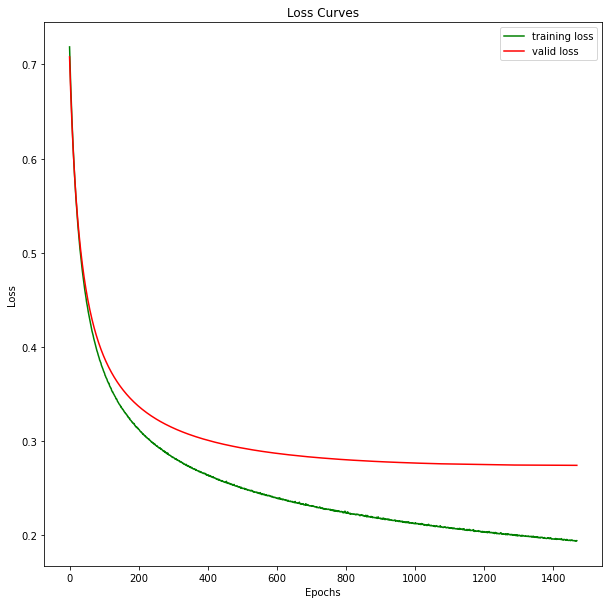

In [8]:
plt.figure(figsize=(10,10))
plt.title('Loss Curves')
plt.plot(
    np.arange(len(train_all_loss)),
              train_all_loss,
              color='green',
              label='training loss')
plt.plot(
    np.arange(len(val_all_loss)), val_all_loss, color='red',
              label='valid loss')
plt.legend()  # 显示图例

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

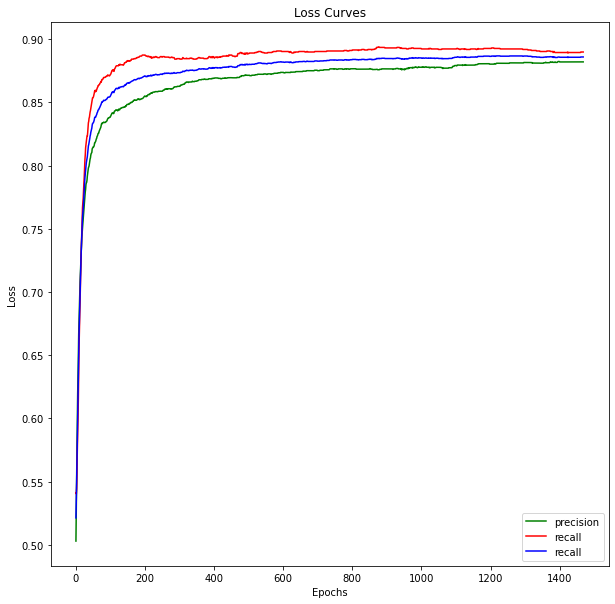

In [9]:
plt.figure(figsize=(10, 10))
plt.title('Loss Curves')
plt.plot(np.arange(len(precision_list)),
         precision_list,
         color='green',
         label='precision')
plt.plot(np.arange(len(recall_list)), recall_list, color='red', label='recall')

plt.plot(np.arange(len(f1_score_list)), f1_score_list, color='b', label='recall')
plt.legend()  # 显示图例

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.show()

## 参考链接
https://www.cnblogs.com/Luv-GEM/p/10888026.html

https://zhuanlan.zhihu.com/p/98061179

https://github.com/FudanNLP/nlp-beginner/blob/master/%E6%96%87%E6%9C%AC%E5%88%86%E7%B1%BB.md